This notebook preprocesses the data for the optimization. First, the heat pump and household loads from the WPuQ data set, which are already in an hourly format, are processed. Then, the electric vehicle data set, which contains 6878 charging sessions in Trondheim, is converted into an hourly format, and the day-ahead market prices from the Bundesnetzagentur’s platform SMARD are edited. This notebook also provides an overview of which charging session is assigned to which household, as well as the share of flexible devices in the total electricity consumption of each household.

### Requirements

Load the necessary packages and define the plotting settings.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

In [2]:
#Plot settings
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 12
plt.style.use("seaborn-v0_8-white")
plt.rcParams['mathtext.fontset']='stix'
plt.rcParams['font.family'] = 'STIXGeneral'

### Data

Read in household hourly data

In [3]:
hh = pd.read_pickle("1920 Final Data w. Additional Features HH Hourly Agg.pkl")

#delete the unnecessary columns
hh.drop(hh.iloc[:, 22:54],inplace=True, axis=1)

Read in heatpump hourly data

In [4]:
hp = pd.read_pickle("1920 Final Data w. Additional Features HP Hourly Agg.pkl")

#delete the unnecessary columns
hp.drop(hp.iloc[:, 22:54],inplace=True, axis=1)

In [5]:
#write household load and heat pump load in one dataframe
hh_names = []
hh_hp = pd.DataFrame()
for i in range (22): 
    hh_names.append(hh.columns[i][:-6])
    hh_column_name = hh.columns[i][:-5]+"HH"
    hh_hp[hh_column_name] = hh.iloc[:,i]/1000 #Umrechnen in kWh
    hp_column_name = hp.columns[i][:-5]+"HP"
    hh_hp[hp_column_name] = hp.iloc[:,i]/1000  #Umrechnen in kWh

In [6]:
#delete all data after 31.01.2020 because EV data ends there

hh_hp = hh_hp[hh_hp.index <= '2020-01-31 23:00']

Read in EV data

In [7]:
ev_raw = pd.read_csv("Dataset 1_EV charging reports.csv",sep=";")

#drop unnecessary columns
ev_raw.drop(ev_raw.iloc[:,11:15],inplace=True, axis=1)
ev_raw = ev_raw.drop('Shared_ID',axis=1)

In [8]:
#convert El_kWh and duration hours to float
ev_raw["El_kWh"] = ev_raw["El_kWh"].str.replace(',', '.')
ev_raw.El_kWh = ev_raw.El_kWh.astype(float)
ev_raw["Duration_hours"] = ev_raw["Duration_hours"].str.replace(',', '.')
ev_raw.Duration_hours = ev_raw.Duration_hours.astype(float)

#drop rows with no end plugout time
ev_raw.dropna(subset = ['End_plugout'], inplace=True)

#only keep private charging sessions the drop User_type colunm
ev = ev_raw[ev_raw['User_type'] != "Shared"]
ev = ev.drop('User_type',axis=1)

#format start plugin and end plugout
ev = ev.copy()
ev.loc[:,'End_plugout'] = pd.to_datetime(ev['End_plugout'], format='%d.%m.%Y %H:%M')
ev.loc[:,'Start_plugin'] = pd.to_datetime(ev['Start_plugin'], format='%d.%m.%Y %H:%M')

#delete all charging processes before 01.01.2019 because HP and HH data starts there
#Convert string to Timestamp
timestamp = pd.Timestamp('2019-01-01 00:00')
ev = ev[ev['End_plugout'] >= timestamp]

#calculate new column with duration minutes
ev['Duration_minutes'] = ev['Duration_hours']*60

#calcualte kWh/min and kW
ev['kWh/min'] = ev['El_kWh']/ev['Duration_minutes']
ev['kW'] = ev['El_kWh']/ev['Duration_hours']

In [9]:
#Get all unique garage IDs
unique_garage = ev['Garage_ID'].unique()

#save as a dataframe
unique_garage_df = pd.DataFrame(unique_garage, columns=['unique_garage'])

#Lists to store user IDs and user information
user_id_raw = []
user_raw = []

#Iterate through the unique garages
for i in range (22):
    
    #Filter ev DataFrame to get unique user IDs for the current garage
    unique_user = ev.loc[ev['Garage_ID'] == unique_garage[i], 'User_ID'].unique()
    
    #Sort the unique user IDs
    unique_user_sorted = sorted(unique_user)
    user_id_raw.extend(unique_user_sorted)
    
    #Iterate through the sorted user IDs
    for u in unique_user_sorted:
        user_raw.append(u)
        user_raw.append(f'{u}_%load')
        
#delete duplicates, because one user charges in two different garages over the time frame
#for user
seen = set()
user = []

for item in user_raw:
    if item not in seen:
        user.append(item)
        seen.add(item)

#for user_id
seen = set()
user_id = []

for item in user_id_raw:
    if item not in seen:
        user_id.append(item)
        seen.add(item)

Create a dataframe for hourly charging processes

In [10]:
#Initializing a dataframe of zeros with index consisting of the timesteps
data = np.zeros((len(hh_hp.index),len(user))) 
ev_hourly = pd.DataFrame(data, index=hh_hp.index, columns=user)

#for user write all charging prozesses in one dataframe df_u_help
for u in user_id:
    df_u_help = ev[ev['User_ID'] == u]
    
    #iterate over every row of df_u_help of one user
    for i in range (len(df_u_help)):
        #define start and end date and hour
        s = df_u_help.iloc[i,3]
        e = df_u_help.iloc[i,5]
        start = s.strftime('%Y-%m-%d %H:00:00+00:00')
        end = e.strftime('%Y-%m-%d %H:00:00+00:00')
        start_con = pd.Timestamp(start).tz_convert('UTC')
        end_con = pd.Timestamp(end).tz_convert('UTC')
        
        #iterate over all indexes of the dataframe ev_hourly
        for index_value in ev_hourly.index:
            
            #if index is bigger than the start point and smaller than the end point then the EV is charged in that timeframe
            if index_value >= start_con and index_value <= end_con:
                
                #calculate the remaining minutes of the start hour and the charged energy if the charing process ends in another hour
                if index_value == start_con and start_con != end_con:
                    minute = 60 - df_u_help.iloc[i,3].minute
                    ev_hourly.loc[index_value,u] = ev_hourly.loc[index_value,u] + minute*df_u_help.iloc[i,10]
                    ev_hourly.loc[index_value,f'{u}_%load'] = ev_hourly.loc[index_value,f'{u}_%load'] + minute/60
                    
                #calculate the minutes and the charged energy if the start and end hour are the same    
                elif index_value == end_con and end_con == start_con:
                    minute = df_u_help.iloc[i,5].minute - df_u_help.iloc[i,3].minute
                    ev_hourly.loc[index_value,u] = ev_hourly.loc[index_value,u] + minute*df_u_help.iloc[i,10]
                    ev_hourly.loc[index_value,f'{u}_%load'] = ev_hourly.loc[index_value,f'{u}_%load']+ minute/60
                    
                #calcualte the remaining minutes of the end hour and the charged energy if the charging process starts in another hour    
                elif index_value == end_con and start_con != end_con:
                    minute = df_u_help.iloc[i,5].minute
                    ev_hourly.loc[index_value,u] = ev_hourly.loc[index_value,u] + minute*df_u_help.iloc[i,10]
                    ev_hourly.loc[index_value,f'{u}_%load'] = ev_hourly.loc[index_value,f'{u}_%load'] + minute/60
                    
                #calculate the charged energy of the full hours between start and end   
                else:
                    ev_hourly.loc[index_value,u] = ev_hourly.loc[index_value,u] + 60*df_u_help.iloc[i,10] 
                    ev_hourly.loc[index_value,f'{u}_%load'] = 1

Split the column for user AsO4-2 into two new columns at the point where the user switches to a different garage. User AsO4-2 charges at station 'AsO4' until the end of August and at station 'MS22' thereafter.

In [11]:
#Date of the switch
specified_date = pd.to_datetime('2019-08-31 23:00:00').tz_localize('UTC')

#Create the new columns
ev_hourly['AsO4-AsO4-2'] = 0.0
ev_hourly['AsO4-AsO4-2_%load'] = 0.0
ev_hourly['MS22-AsO4-2'] = 0.0
ev_hourly['MS22-AsO4-2_%load'] = 0.0

#Iterate through all timesteps
for index_value in ev_hourly.index:
    
    #Before the switch to garage MS22
    if index_value <= specified_date:
        ev_hourly.loc[index_value,'AsO4-AsO4-2'] = ev_hourly.loc[index_value,'AsO4-2']
        ev_hourly.loc[index_value,'AsO4-AsO4-2_%load'] = ev_hourly.loc[index_value,'AsO4-2_%load']
        ev_hourly.loc[index_value,'MS22-AsO4-2'] = 0
        ev_hourly.loc[index_value,'MS22-AsO4-2_%load'] = 0
    
    #After the switch to garage MS22
    else:
        ev_hourly.loc[index_value,'AsO4-AsO4-2'] = 0
        ev_hourly.loc[index_value,'AsO4-AsO4-2_%load'] = 0
        ev_hourly.loc[index_value,'MS22-AsO4-2'] = ev_hourly.loc[index_value,'AsO4-2']
        ev_hourly.loc[index_value,'MS22-AsO4-2_%load'] = ev_hourly.loc[index_value,'AsO4-2_%load']

#Delete the original columns
columns_to_delete = ['AsO4-2', 'AsO4-2_%load']

#Use the drop method to delete the columns
ev_hourly = ev_hourly.drop(columns=columns_to_delete)

Plot total household consumption splitted in HH, HP and EV

C:\Users\bianca\AppData\Local\Temp\ipykernel_25376\2019234893.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hh_sum.append(hh_hp_sum[2*i])
C:\Users\bianca\AppData\Local\Temp\ipykernel_25376\2019234893.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hp_sum.append(hh_hp_sum[2*i+1])
C:\Users\bianca\AppData\Local\Temp\ipykernel_25376\2019234893.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_sum += pre_sum[i*2]


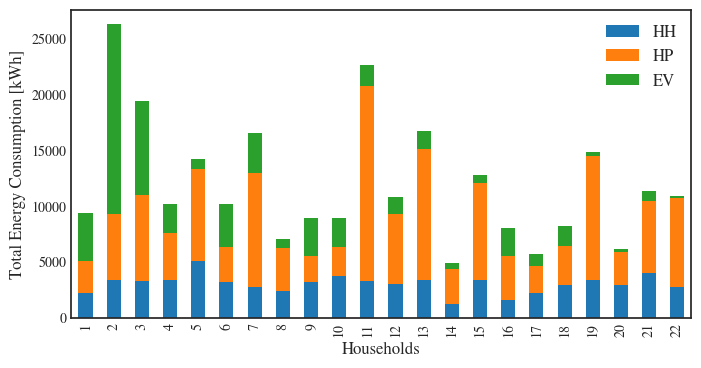

In [12]:
hh_hp_sum = hh_hp.sum()
hh_sum=[]
hp_sum=[]
ev_sum=[]
for i in range(len(hh_hp.columns)//2):
    hh_sum.append(hh_hp_sum[2*i])
    hp_sum.append(hh_hp_sum[2*i+1])
for i in range(22):
    total_sum = 0
    selected_columns = ev_hourly.filter(regex=f'^{unique_garage[i]}-', axis=1)
    pre_sum = selected_columns.sum()
    for i in range(len(pre_sum)//2):
        total_sum += pre_sum[i*2]
    ev_sum.append(total_sum)
df_bar= pd.DataFrame({'HH':hh_sum,'HP':hp_sum,'EV':ev_sum})
df_bar.index=range(1,23)
fig, ax = plt.subplots(figsize=(8, 4))
df_bar.plot.bar(stacked=True, ax=ax)
#plt.title('Household Consumption divided in HP, HH and EV')
plt.xlabel('Households')
plt.ylabel('Total Energy Consumption [kWh]')
plt.savefig('TotalHHConsumption.png')
plt.show()

Determine the share of shiftable devices in each household's total consumption.

In [13]:
part_hh=[]
part_hp=[]
part_ev=[]
part_shiftable=[]
for i in range(22):
    part_hh.append(hh_sum[i]/(hh_sum[i]+hp_sum[i]+ev_sum[i])*100)
    part_hp.append(hp_sum[i]/(hh_sum[i]+hp_sum[i]+ev_sum[i])*100)
    part_ev.append(ev_sum[i]/(hh_sum[i]+hp_sum[i]+ev_sum[i])*100)
    part_shiftable.append((ev_sum[i]+hp_sum[i])/(hh_sum[i]+hp_sum[i]+ev_sum[i])*100)

share = pd.DataFrame()
share["share of HH"] = part_hh
share["share of HP"] = part_hp
share["share of EV"] = part_ev
share["share of shiftable devices"]= part_shiftable
share.index = np.arange(1, 23)
rounded_share = share.round(2)
rounded_share

,share of HH,share of HP,share of EV,share of shiftable devices
1,23.96,30.64,45.39,76.04
2,12.85,22.32,64.84,87.15
3,17.14,39.68,43.18,82.86
4,33.09,40.95,25.96,66.91
5,35.75,58.18,6.07,64.25
6,31.11,31.55,37.34,68.89
7,16.78,61.60,21.63,83.22
8,33.91,55.06,11.02,66.09
9,35.81,25.70,38.49,64.19
10,41.81,28.93,29.26,58.19


Calculate the minimum peak load per garage (needed as the maximum charging power per wallbox in the optimization).

In [14]:
#Determine min_peak per garage
min_peak = []

#Iterate through unique garages
for i in range(22):
    min_peak.append(ev.loc[ev['Garage_ID'] == unique_garage[i],'kW'].max())

#save as a dataframe
min_peak_df = pd.DataFrame(min_peak, columns=['Min_Peak_Load'])

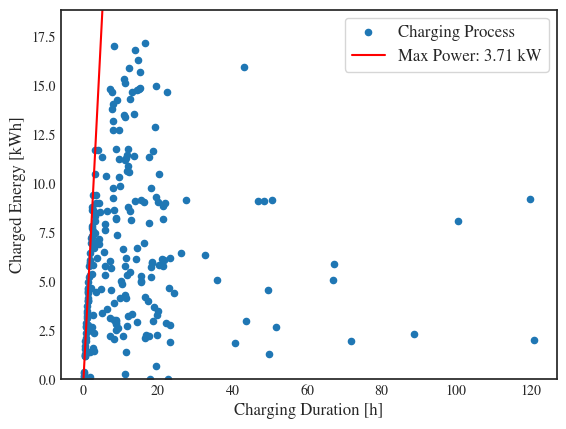

In [15]:
#Plot charging processes to verify min_peak

garage_data = ev[ev['Garage_ID'] == unique_garage[11]]
max_kwh_gradient = garage_data['kW'].max()
line_x = np.linspace(0, 10, 10)
line_y = max_kwh_gradient * line_x
plt.scatter(x= garage_data['Duration_hours'],y=garage_data['El_kWh'], label='Charging Process', s=20)
plt.plot(line_x, line_y, color='red', linestyle='-', label=f'Max Power: {max_kwh_gradient:.2f} kW')
plt.ylim(0,garage_data['El_kWh'].max()*1.1)
plt.xlabel('Charging Duration [h]')
plt.ylabel('Charged Energy [kWh]')
#plt.title(f'Scatter Plot for Charger ID {unique_garage[11]} with Maximum Power Line')
plt.legend(frameon=True)
plt.savefig('MinMaxLoadPerCharger.png')
plt.show()

Read in Day Ahead Prices

In [16]:
p_flex = pd.read_csv("Gro_handelspreise_201901010000_202001312359_Stunde.csv",sep=";")

#Only keep necessary columns
p_flex = p_flex[['Datum', 'Anfang', 'Deutschland/Luxemburg [€/MWh] Originalauflösungen']]

#Rename columns
p_flex = p_flex.rename(columns={"Deutschland/Luxemburg [€/MWh] Originalauflösungen": "price"})
p_flex = p_flex.rename(columns={"Anfang":"Time"})
p_flex = p_flex.rename(columns={"Datum":"Date"})

#Transform index to datetime format
p_flex['DateTime'] = pd.to_datetime(p_flex['Date'] + ' ' + p_flex['Time'], format='%d.%m.%Y %H:%M')
p_flex.index = p_flex.DateTime

#drop date, time and datetime
p_flex = p_flex.drop(columns=['Date', 'Time','DateTime'])

#Convert price to float
p_flex["price"] = p_flex["price"].str.replace(',', '.')
p_flex.price = p_flex.price.astype(float)

#Convert price to kWh
p_flex["price"] = p_flex["price"]/1000
p_flex = p_flex.rename(columns={"price":"price [€/kWh]"})

In [17]:
#Save the timesteps and dates in a dataframe
date_column = ev_hourly.index
date = pd.DataFrame({'date': date_column})

Dictionarys

In [18]:
#Dictionary for households
hh_dic={1:"SFH3_HH",2:"SFH4_HH",3:"SFH5_HH",4:"SFH7_HH",5:"SFH9_HH",6:"SFH12_HH",7:"SFH14_HH",8:"SFH16_HH",9:"SFH18_HH",10:"SFH19_HH",
        11:"SFH20_HH",12:"SFH21_HH",13:"SFH22_HH",14:"SFH27_HH",15:"SFH28_HH",16:"SFH29_HH",17:"SFH30_HH",18:"SFH32_HH",19:"SFH34_HH",
        20:"SFH36_HH",21:"SFH38_HH",22:"SFH39_HH"}

In [19]:
#Dictionary for heatpumps
hp_dic={1:"SFH3_HP",2:"SFH4_HP",3:"SFH5_HP",4:"SFH7_HP",5:"SFH9_HP",6:"SFH12_HP",7:"SFH14_HP",8:"SFH16_HP",9:"SFH18_HP",10:"SFH19_HP",
        11:"SFH20_HP",12:"SFH21_HP",13:"SFH22_HP",14:"SFH27_HP",15:"SFH28_HP",16:"SFH29_HP",17:"SFH30_HP",18:"SFH32_HP",19:"SFH34_HP",
        20:"SFH36_HP",21:"SFH38_HP",22:"SFH39_HP"}

Calculate empirical household load

In [20]:
#Baseline load with without shifting (sum of HH,HP and EV consumption in every hour per household)
def baseline(hh, hp, ev):
    
    load = []
    
    #calculate the consumption in every time step
    for i in range(len(hh)):
        con = (hh.iloc[i]+hp.iloc[i])
        for j in range(len(ev.columns)//2):
            con += ev.iloc[i,j*2]
        
        load.append(con)
        #Save load in every time step
        
    #Return load without shifting
    return load

In [21]:
load_before_shift = pd.DataFrame()

#Iterate over all households
for i in range(len(min_peak_df)):
    
    #Select all users per garage
    selected_columns = ev_hourly.filter(regex=f'^{unique_garage[i]}-', axis=1)
    
    #Calculate Baseline
    load = baseline(hh_hp[hh_dic[i+1]],hh_hp[hp_dic[i+1]], selected_columns)
    
    #Store shifted loads per household
    load_df = pd.DataFrame(load, columns=['load'])
    load_before_shift[f"{hh_dic[i+1]}_d"] = load_df.iloc[:,0]

Provide an overview of which garage is assigned to each household.

In [22]:
overview = pd.DataFrame()
overview['Household ID']=hh_names
overview['Charging Station ID'] =unique_garage[:-1]
overview

,Household ID,Charging Station ID
0,SFH3,AdO3
1,SFH4,Bl2
2,SFH5,AdO1
3,SFH7,AsO2
4,SFH9,Bl7
5,SFH12,SR14
6,SFH14,SR2
7,SFH16,AsO4
8,SFH18,AsO10
9,SFH19,MS22


### Save the edited data as csv

In [23]:
ev_hourly.to_csv('Hourly_EV_Charging.csv')
hh_hp.to_csv('Hourly_HH_HP.csv')
min_peak_df.to_csv('Min_Peak_Load.csv', index=False)
p_flex.to_csv('Hourly_Flexible_Prices.csv', index=False)
unique_garage_df.to_csv('Unique_Garage.csv', index=False)
date.to_csv('Date.csv', index=False)
load_before_shift.to_csv('load_before_shift.csv')